# 训练及测试
注意：请先按照`dataset.ipynb`准备数据集
如果需要使用已经训练好的参数，请将其放入`notebook/ouputs`文件夹
### 测试数据集是否正常
#### 查看数据集中各分类标注个数

In [1]:
from pycocotools.coco import COCO

coco = COCO('../data/task.json')
cocoIds = coco.getCatIds()
cocoCats = {}
totalRemove = 0
for it in cocoIds:
	images = len(coco.getImgIds(catIds=[it]))
	catName = coco.loadCats(it)[0]['name']
	if images > 500:
		totalRemove += images - 500
	cocoCats[catName] = images
print(totalRemove)
print(len(coco.getImgIds()))
cocoCats

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
11220
16202


{'CA001': 1440,
 'CA002': 826,
 'CA003': 1071,
 'CA004': 572,
 'CB001': 1305,
 'CB002': 537,
 'CB003': 922,
 'CB004': 1282,
 'CC001': 2735,
 'CC002': 2261,
 'CC003': 669,
 'CC004': 3550,
 'CD001': 550,
 'CD002': 332,
 'CD003': 10,
 'CD004': 474}

#### 从数据集中随机抽取图片和标注信息并显示

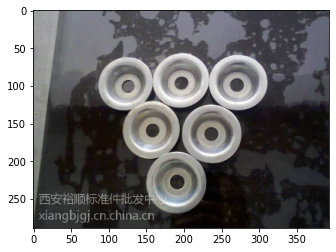

In [31]:
from detectron2.data.datasets import load_coco_json
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
import matplotlib.pyplot as plt

dataset_dicts = load_coco_json('../data/task.json', '../data/image')

d = random.choice(dataset_dicts)
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("task"), scale=0.5)
out = visualizer.draw_dataset_dict(d)
b,g,r = cv2.split(out.get_image()[:, :, ::-1])
plt.imshow(cv2.merge([r,g,b]))

### 注册数据集

In [1]:
from detectron2.data.datasets import register_coco_instances
import os

register_coco_instances('task', {}, "../data/task.json", "../data/image")

### 配置训练参数

In [4]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
# cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ('task',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = 'resnet18-f37072fd.pth'
cfg.INPUT.MIN_SIZE_TRAIN = 480
cfg.SOLVER.IMS_PER_BATCH = 12
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.MAX_ITER = 10000   # = imgNumber / IMS_PER_BATCH * epoch
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 16   # catNumber
cfg.MODEL.RESNETS.DEPTH = 18
cfg.MODEL.RESNETS.STRIDE_IN_1X1 = False
cfg.MODEL.RESNETS.RES2_OUT_CHANNELS = 64
cfg.MODEL.PIXEL_MEAN = [123.675, 116.280, 103.530]
cfg.MODEL.PIXEL_STD = [58.395, 57.120, 57.375]
cfg.INPUT.FORMAT = "RGB"

### 开始训练

In [5]:
from detectron2.engine import DefaultTrainer
import os

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/04 17:05:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_9243eb.pkl: 144MB [00:47, 3.06MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (17, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (17,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (64, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (64,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model d

[04/04 17:06:44 d2.engine.train_loop]: Starting training from iteration 0


/home/bismarck/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[04/04 17:07:32 d2.engine.hooks]: Total training time: 0:00:02 (0:00:00 on hooks)
[04/04 17:07:32 d2.utils.events]:  iter: 1  total_loss: 3.476  loss_cls: 2.511  loss_box_reg: 0.1299  loss_mask: 0.6923  loss_rpn_cls: 0.1414  loss_rpn_loc: 0.001379  data_time: 0.0701  lr: 5e-06  


KeyboardInterrupt: 

### 加载训练好的参数

In [11]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
cfg.MODEL.DEVICE = 'cpu'
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 16   # catNumber
cfg.MODEL.RESNETS.DEPTH = 18
cfg.MODEL.RESNETS.STRIDE_IN_1X1 = False
cfg.MODEL.RESNETS.RES2_OUT_CHANNELS = 64
cfg.MODEL.PIXEL_MEAN = [123.675, 116.280, 103.530]
cfg.MODEL.PIXEL_STD = [58.395, 57.120, 57.375]
cfg.INPUT.FORMAT = "RGB"
predictor = DefaultPredictor(cfg)

### 使用训练好的模型进行推理测试

Instances(num_instances=18, image_height=640, image_width=480, fields=[pred_boxes: Boxes(tensor([[251.7705, 309.5973, 271.8553, 336.2484],
        [143.5349, 258.5562, 167.1850, 345.3958],
        [294.8153, 382.3390, 347.6635, 467.9954],
        [250.7608, 412.3455, 316.6773, 486.5897],
        [268.6424, 224.7919, 353.9081, 307.2206],
        [116.2082, 111.4236, 153.2331, 148.9466],
        [308.4156, 264.2016, 342.7978, 305.9280],
        [142.6234,  70.3291, 173.9405, 107.5290],
        [220.2645, 218.5118, 245.1398, 299.6162],
        [308.5041, 269.4418, 327.1948, 293.7858],
        [ 34.8156, 330.2885,  61.1938, 406.9079],
        [295.7264, 376.1566, 341.6734, 432.2755],
        [301.2525, 253.0345, 345.3913, 307.4336],
        [164.8761,  48.3910, 194.7219,  67.1997],
        [221.3416, 329.5758, 240.8725, 357.3843],
        [168.7034,  40.2418, 195.7077, 108.4498],
        [237.5693, 125.0427, 263.1150, 196.4723],
        [239.3922, 150.5889, 268.8225, 186.4755]])), scores: 

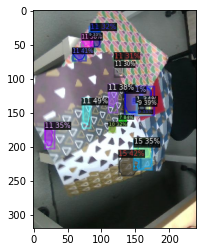

In [14]:
%%time
import cv2
from detectron2.data.datasets import load_coco_json
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt
import random

dataset_dicts = load_coco_json('../data/task.json', '../data/image')
d = random.choice(dataset_dicts)
im = cv2.imread(d["file_name"])
outputs = predictor(im)
v = visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("task"), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
print(outputs["instances"].to("cpu"))
cv2.imwrite('res.jpg', out.get_image()[:, :, ::-1])
plt.imshow(out.get_image())